# Iris

Exploring the iris dataset and building some models.

## Prereqs

- python=3.8
- install requirements.txt


In [1]:
print("hello world")

hello world


## Get Data

Get the iris data from Azure.

In [2]:
data_uri = "https://azuremlexamples.blob.core.windows.net/datasets/iris.csv"
data_uri

'https://azuremlexamples.blob.core.windows.net/datasets/iris.csv'

In [3]:
import pandas as pd

df = pd.read_csv(data_uri)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Exploratory Data Analysis (EDA)

Explore the data.

In [4]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
labels = set(df.species)
labels

{'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'}

In [6]:
kbs = df.memory_usage(deep=True, index=True).sum() / 1e3
kbs

15.478

let's save some bytes

In [7]:
df.species = df.species.str.replace("Iris-", "")

labels = set(df.species)
labels

{'setosa', 'versicolor', 'virginica'}

In [8]:
kbs = df.memory_usage(deep=True, index=True).sum() / 1e3
kbs

14.728

setup plotting with seaborn and matplotlib

In [9]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_style("darkgrid")
# mpl.rcParams["figure.facecolor"] = "black"
plt.style.use(["dark_background"])

let's plot ``sepal_length`` vs ``sepal_width``

<AxesSubplot:xlabel='sepal_length', ylabel='sepal_width'>

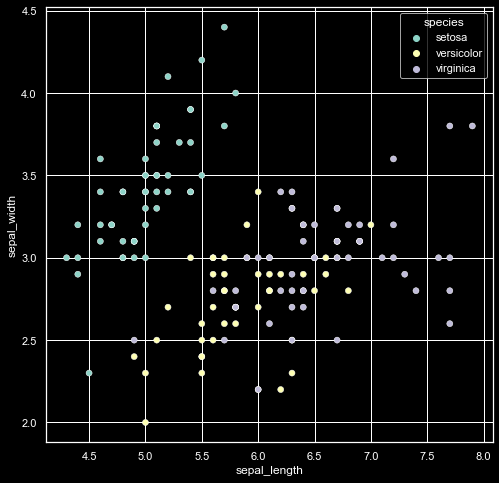

In [10]:
f, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=df, x="sepal_length", y="sepal_width", hue="species")

let's plot ``petal_length`` vs ``petal_width``

<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

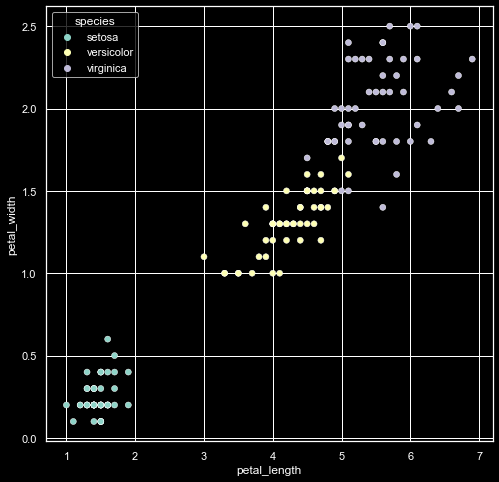

In [11]:
f, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=df, x="petal_length", y="petal_width", hue="species")

since there are only 4 features and they are all reasonable scaled numbers, we can simply visualize all combinations of features in 2D to get a sense of how we can separate the species

In [12]:
features = ["petal_width", "petal_length", "sepal_width", "sepal_length"]
features

['petal_width', 'petal_length', 'sepal_width', 'sepal_length']

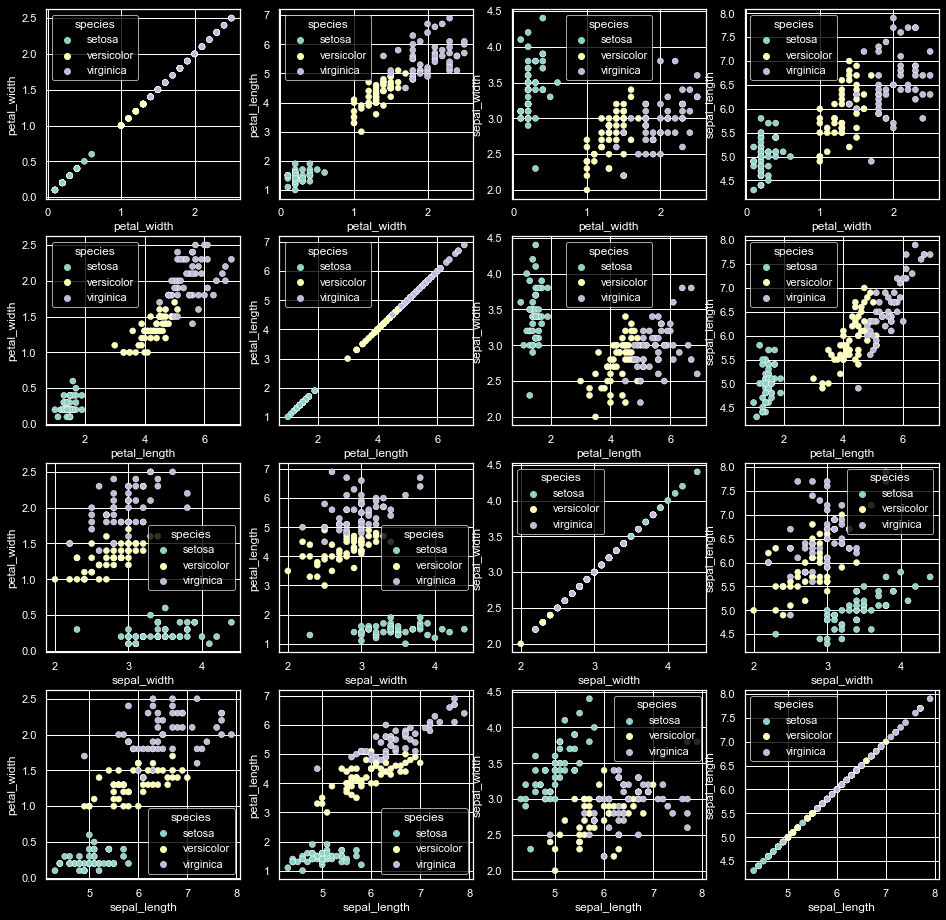

In [13]:
n = len(features)

fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(16, 16))

for i in range(n):
    for j in range(n):
        x = features[i]
        y = features[j]

        sns.scatterplot(data=df, x=x, y=y, hue="species", ax=axes[i, j])

## Feature Engineering

Create some new features.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [15]:
df["f1"] = df.petal_width ** 2 + df.petal_length ** 2
df["f2"] = df.sepal_width ** 2 + df.sepal_length ** 2
df["f3"] = df.petal_width ** 2 + df.sepal_length ** 2
df["f4"] = df.sepal_width ** 2 + df.petal_length ** 2
df["f5"] = df.sepal_width ** 2 + df.petal_width ** 2
df["f6"] = df.sepal_length ** 2 + df.petal_length ** 2

<AxesSubplot:xlabel='f5', ylabel='f6'>

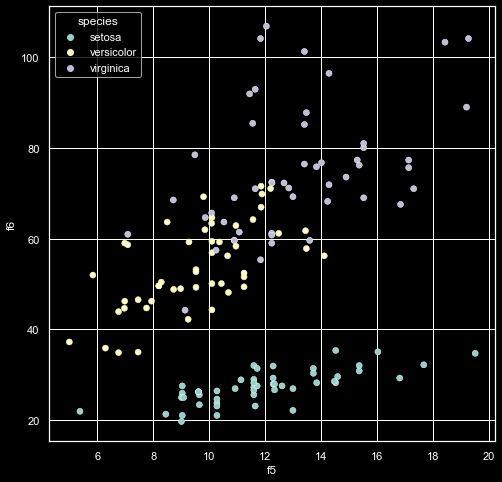

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=df, x="f5", y="f6", hue="species")

In [17]:
features = ["f1", "f2", "f3", "f4", "f5", "f6"]
features

['f1', 'f2', 'f3', 'f4', 'f5', 'f6']

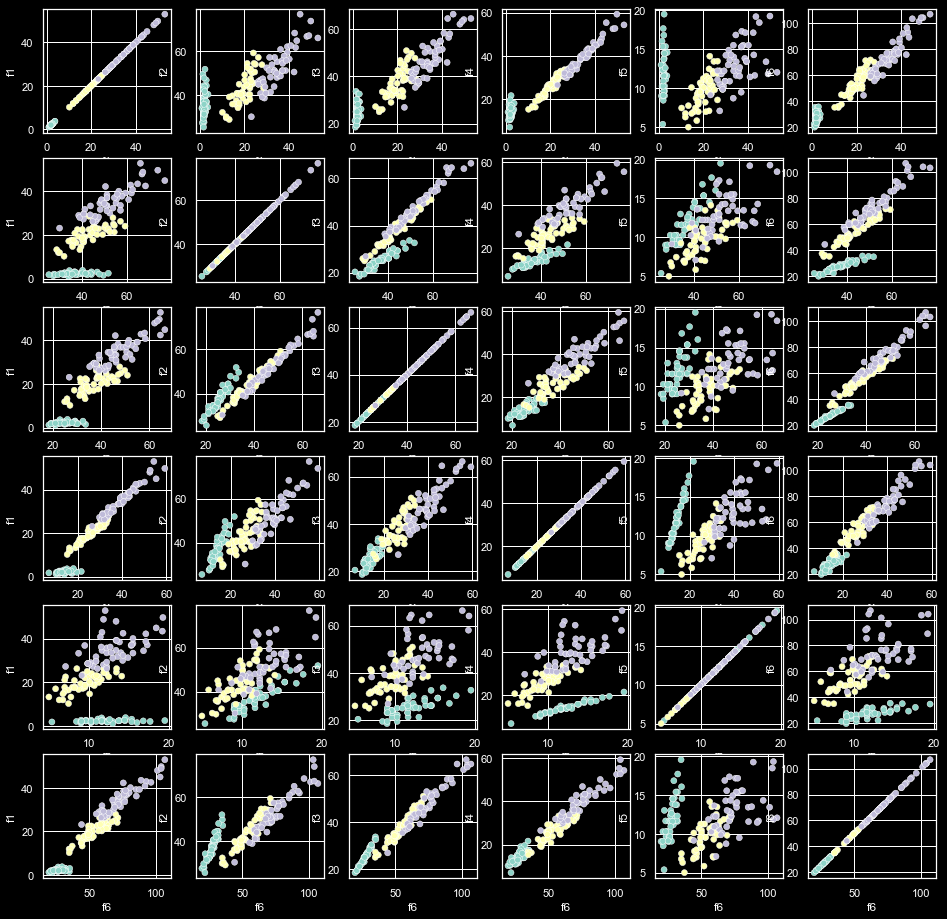

In [18]:
n = len(features)

fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(16, 16))

for i in range(n):
    for j in range(n):
        x = features[i]
        y = features[j]

        sns.scatterplot(
            data=df, x=x, y=y, hue="species", ax=axes[i, j], legend=False
        )

## Build a System

Define a system in PyTorch-Lightning.

In [19]:
# re-read the data
df = pd.read_csv(data_uri)

# perform any data processing
df.species = df.species.str.replace("Iris-", "")

# double check the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


pull out X and y

In [20]:
X = df.drop("species", axis=1).values
y = df.species.values

print a sample

In [21]:
print(f"Sample: X = {X[0]} and y = {y[0]}")

Sample: X = [5.1 3.5 1.4 0.2] and y = setosa


define our system by gaining a deep visual understanding of our data and applying advanced statistical techniques

In [22]:
class System:
    def __init__(self):
        pass

    def forward(self, x):
        # unpack array
        sepal_length, sepal_width, petal_length, petal_width = x

        # setosa
        if petal_width < 0.9 and petal_length < 2.7:
            return "setosa"

        # versicolor
        elif petal_length < 5.1 and petal_width < 1.6:
            return "versicolor"

        # virginica
        else:
            return "virginica"

initialize the system - no training neccesary!

In [23]:
system = System()

try it out on a sample

In [24]:
res = system.forward(X[0])
print(res)

setosa


now let's try to see how the system performs

In [25]:
import numpy as np

results = np.array([system.forward(x) for x in X])

In [26]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y, results)
acc

0.96

## PyTorch Detour

Turns out I forgot how to do things. To the blitz!

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [28]:
x = X[0]
x

array([5.1, 3.5, 1.4, 0.2])

In [29]:
x.shape

(4,)

In [30]:
t = torch.from_numpy(x)
t

tensor([5.1000, 3.5000, 1.4000, 0.2000], dtype=torch.float64)

In [31]:
t.shape

torch.Size([4])

In [32]:
t.dtype

torch.float64

In [33]:
t.device

device(type='cpu')

In [34]:
l1 = nn.Linear(4, 64)

In [35]:
z = l1(t.float())
z

tensor([-3.0419,  0.6994,  2.1097, -3.2135,  0.1409, -1.3512, -0.3032,  1.4931,
         2.0374,  1.7794, -1.6369,  1.3775,  0.0562, -0.2295, -0.6007,  0.3576,
         1.7477, -1.3807,  2.1515, -1.6585,  1.0816,  2.2662, -3.0145,  0.3468,
        -0.5551, -1.4885, -1.5949,  1.1194, -1.5931,  0.9615,  2.7939,  1.7761,
        -2.5360,  1.3333,  0.5935, -3.9581, -0.6902, -1.6507,  1.6283,  1.2690,
        -2.4649,  0.9535,  1.8399, -4.0315, -1.0235, -2.3319, -2.2680,  0.2561,
         2.2199, -3.2902, -0.0250, -0.0181, -3.9974,  1.9997,  0.1487,  3.3339,
         1.5446,  0.3228,  1.1340, -0.3564,  2.2779,  2.0091, -1.8865,  1.5051],
       grad_fn=<AddBackward0>)

In [36]:
enc = nn.Sequential(nn.Linear(4, 64), nn.ReLU(), nn.Linear(64, 64))
enc

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
)

In [37]:
a = enc(t.float())
a

tensor([-3.3162e-01,  6.4680e-01, -4.9246e-01, -9.3050e-02,  2.7129e-01,
         1.2062e+00, -1.4194e-01, -3.9113e-01, -8.0427e-01, -1.0054e+00,
         8.1350e-01,  3.0155e-01,  1.0534e+00,  9.2767e-01, -6.3153e-01,
        -3.0354e-01, -9.6947e-01, -1.6464e+00, -8.5494e-01,  1.8154e+00,
        -2.0049e-02,  2.0242e-01, -1.7731e-01, -6.3276e-02, -6.8312e-01,
         7.0698e-01,  1.6672e-01, -5.0717e-01, -4.8675e-01, -2.3572e-02,
        -4.3575e-01,  5.9456e-02,  3.3548e-01,  1.2990e+00, -3.3402e-01,
        -1.5924e-01,  8.4107e-01, -9.9239e-01, -1.4163e-01, -3.2673e-01,
        -5.8851e-01,  7.2366e-01,  2.7271e-02,  2.1766e+00,  1.6659e+00,
        -1.2655e+00, -1.4536e+00,  2.4890e-01, -4.6244e-02, -3.6110e-01,
        -7.3346e-01, -1.0129e+00, -2.5933e-01, -3.8813e-01, -2.0684e-01,
        -1.0225e-01, -7.9764e-01,  5.3723e-01,  1.0386e+00,  1.6138e-01,
         6.8790e-01,  1.6970e-03,  1.4671e+00, -3.0074e-01],
       grad_fn=<AddBackward0>)

In [38]:
dec = nn.Sequential(nn.Linear(64, 3), nn.Softmax())
dec

Sequential(
  (0): Linear(in_features=64, out_features=3, bias=True)
  (1): Softmax(dim=None)
)

In [39]:
b = dec(a)
b

tensor([0.3039, 0.4631, 0.2330], grad_fn=<SoftmaxBackward>)

## Learn a System

Build a system by learning from data!

In [40]:
import torch

import pytorch_lightning as pl

from torch import nn
from torch.nn import functional as F


class System(pl.LightningModule):
    def __init__(self):
        # magic
        super().__init__()

        # simple MLP
        # self.net = nn.Sequential(nn.Linear(4, 64), nn.ReLU(), nn.Linear(64, 3), nn.Softmax())

        # #deeplearning
        self.net = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
            nn.Softmax(),
        )

    def forward(self, x):
        x = self.net(x.float()) if type(x) is torch.Tensor else self.net(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy(y_hat, y.float())
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-4)
        return optimizer

In [41]:
system = System()

now we need the data...

In [42]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder


class IrisDataset(torch.utils.data.IterableDataset):
    def __init__(self):
        super().__init__()

        data_uri = (
            "https://azuremlexamples.blob.core.windows.net/datasets/iris.csv"
        )

        # re-read the data
        df = pd.read_csv(data_uri)

        # perform any data processing
        df.species = df.species.str.replace("Iris-", "")

        # get X and y
        X = df.drop("species", axis=1).values
        y = df.species.values

        # one-hot encode the output
        ohe = OneHotEncoder().fit(y.reshape(-1, 1))
        y = ohe.transform(y.reshape(-1, 1)).toarray()

        # assign to self
        self.X = X
        self.y = y
        self.ohe = ohe

    def __iter__(self):
        return iter(zip(self.X, self.y))

    def __len__(self):
        return len(self.X)


ds = IrisDataset()
ds

In [43]:
from torch.utils.data import DataLoader

dl = DataLoader(ds)
dl

In [44]:
next(iter(dl))

[tensor([[5.1000, 3.5000, 1.4000, 0.2000]], dtype=torch.float64),
 tensor([[1., 0., 0.]], dtype=torch.float64)]

In [45]:
x, y = next(iter(dl))
print(f"x: {x}\ny: {y}")

x: tensor([[5.1000, 3.5000, 1.4000, 0.2000]], dtype=torch.float64)
y: tensor([[1., 0., 0.]], dtype=torch.float64)


now we can train! 

In [46]:
%%time
trainer = pl.Trainer(max_epochs=100)
trainer.fit(system, dl)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params


Epoch 99: 100%|██████████| 150/150 [00:01<00:00, 144.35it/s, loss=0.0393, v_num=32]
CPU times: user 51.9 s, sys: 5.66 s, total: 57.6 s
Wall time: 58.6 s


1

and test as before 

In [47]:
# re-read the data
df = pd.read_csv(data_uri)

# perform any data processing
df.species = df.species.str.replace("Iris-", "")

# pull out X and y
X = df.drop("species", axis=1).values
y = df.species.values

In [48]:
x = X[0]
x

array([5.1, 3.5, 1.4, 0.2])

In [49]:
res = ds.ohe.inverse_transform(
    system.forward(torch.from_numpy(x)).detach().numpy().reshape(1, -1)
)
res[0][0]

'setosa'

In [50]:
results = np.array(
    [
        ds.ohe.inverse_transform(
            system.forward(torch.from_numpy(x)).detach().numpy().reshape(1, -1)
        )[0][0]
        for x in X
    ]
)
# results

In [51]:
# y

In [52]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y, results)
acc

0.96

## Recap

We: 

- did this
- did that 
- etc

## Docs

In [53]:
sns.scatterplot?

Signature:
sns.scatterplot(
    *,
    x=None,
    y=None,
    hue=None,
    style=None,
    size=None,
    data=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    sizes=None,
    size_order=None,
    size_norm=None,
    markers=True,
    style_order=None,
    x_bins=None,
    y_bins=None,
    units=None,
    estimator=None,
    ci=95,
    n_boot=1000,
    alpha=None,
    x_jitter=None,
    y_jitter=None,
    legend='auto',
    ax=None,
    **kwargs,
)
Docstring:
Draw a scatter plot with possibility of several semantic groupings.

The relationship between ``x`` and ``y`` can be shown for different subsets
of the data using the ``hue``, ``size``, and ``style`` parameters. These
parameters control what visual semantics are used to identify the different
subsets. It is possible to show up to three dimensions independently by
using all three semantic types, but this style of plot can be hard to
interpret and is often ineffective. Using redundant semantics (i.e. both
``hue``